# Difference between two rates

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'

In this section we will estimate the difference between two binomial
rates according to the following model:

### Simulator

In [ ]:
def context():
    return dict(
        n=np.random.randint(1, 101, size=2)
    )

def prior():
    theta=np.random.beta(a=1, b=1, size=2)

    return dict(theta=theta, delta=theta[0]-theta[1])

def likelihood(n, theta):
    k=np.random.binomial(n=n, p=theta)

    return dict(k=k)

simulator = bf.make_simulator([context, prior, likelihood])


### Approximator

In [ ]:
adapter=(
    bf.Adapter()
    .constrain("delta", lower=-1, upper=1)
    .rename("delta", "inference_variables")
    .concatenate(["k", "n"], into="inference_conditions")
)

In [ ]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

In [ ]:
history=workflow.fit_online(epochs=20, batch_size=512)

### Validation

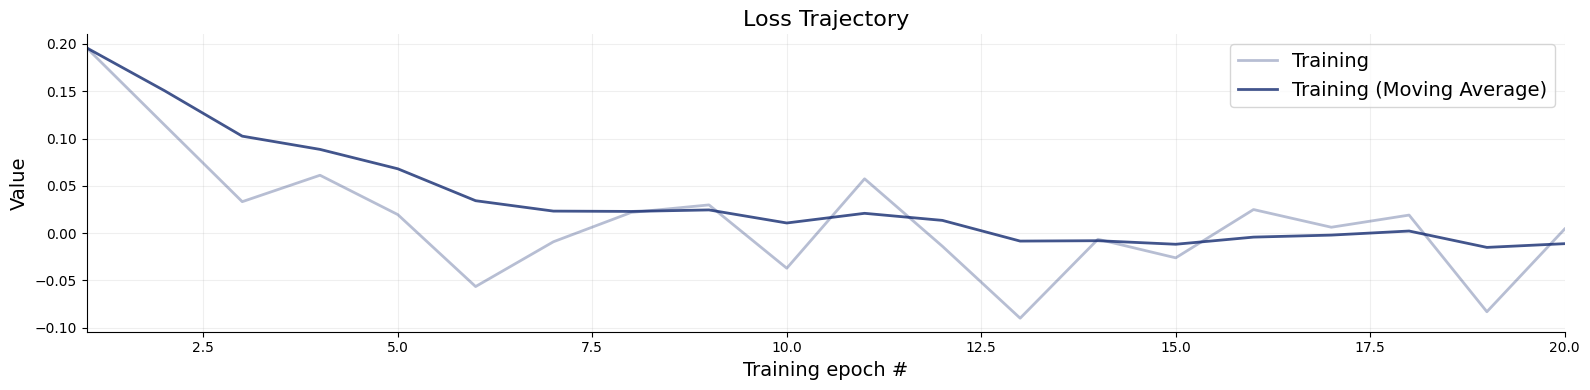

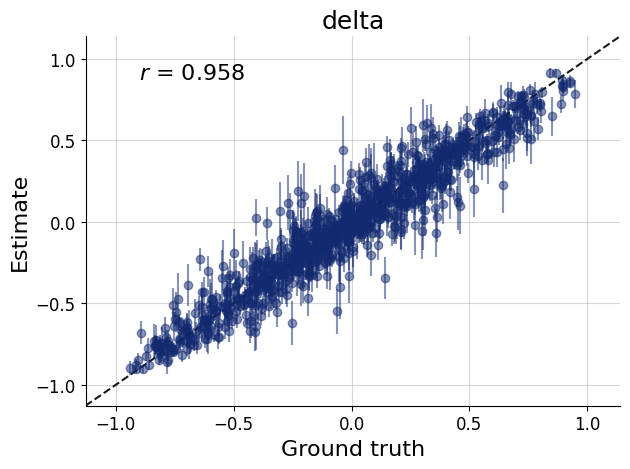

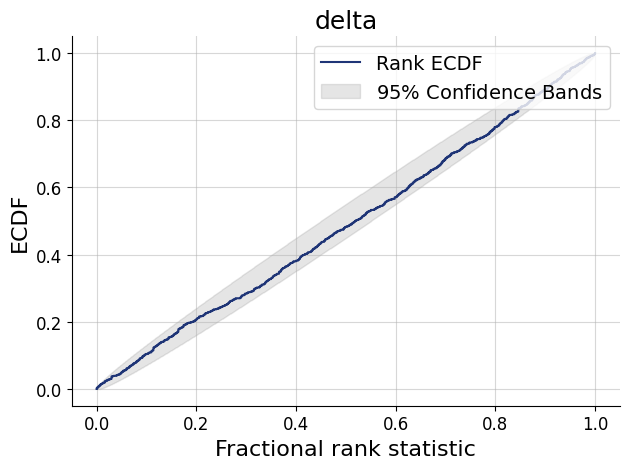

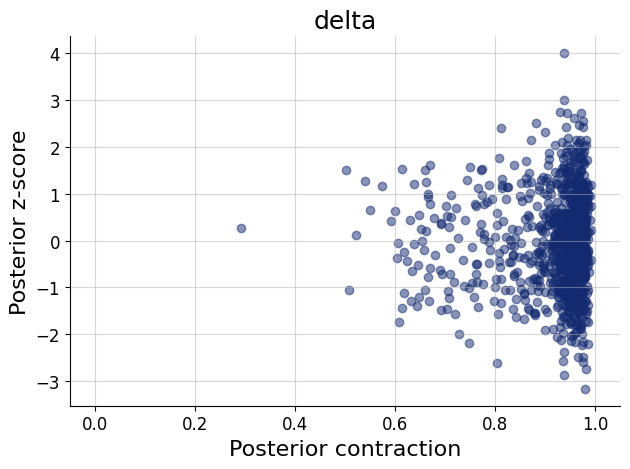

In [9]:
test_data=simulator.sample(1000)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Here we estimate the parameters with $k_1 = 5$, $k_2 = 7$,
$n_1 = n_2 = 10$.

In [ ]:
inference_data=dict(
    k = np.array([[5, 7]]),
    n = np.array([[10, 10]])
)

In [11]:
samples=workflow.sample(num_samples=2000, conditions=inference_data)

In [12]:
workflow.samples_to_data_frame(samples).describe()

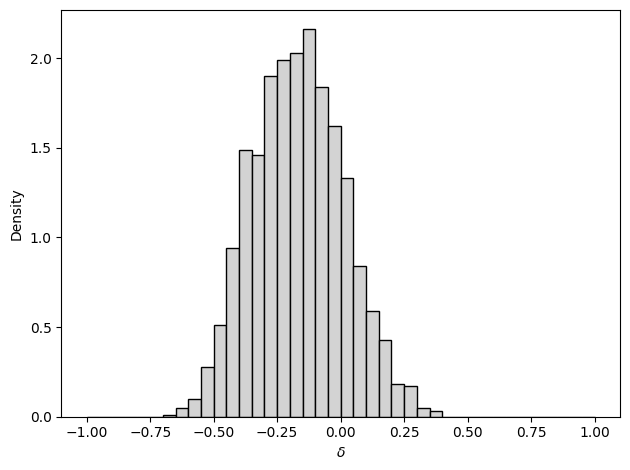

In [14]:
plt.hist(samples["delta"].flatten(), density=True, color="lightgray", edgecolor="black", bins=np.arange(-1, 1.05, 0.05))
plt.xlabel(r"$\delta$")
plt.ylabel("Density")
plt.tight_layout()